# Analysis of Feature Similarity with Target Variable
Given that the time-series nature of the Santander datasets has become exposed to the Kaggle community, I will be conducting an exploration of various features' correlation with the target variable.

In [22]:
# Load libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import h5py
import pickle

## Helper Functions

In [2]:
# Function for loading h5py file
def load_h5py(fname):
    with h5py.File(fname, 'r') as handle:
        return handle['data'][:]
# Function for loading pickle file
def load_pickle(fname):
    with open(fname, 'rb') as handle:
        return pickle.load(handle)

In [3]:
# Function for setting up
def get_input(debug=False):
    '''
    Function for loading either debug or full datasets
    '''
    os.chdir('../../data/compressed/')
    print os.getcwd()
    pkl_files = ['train_id.pickle', 'trainidx.pickle', 'target.pickle', 'test_id.pickle', 'testidx.pickle']
    if debug:
        print 'Loading debug train and test datasets...'
        # h5py files
        train = load_h5py('debug_train.h5')
        test = load_h5py('debug_test.h5')
        # pickle files
        id_train, train_idx, target, id_test, test_idx = [load_pickle('debug_%s'%f) for f in pkl_files]
    else:
        print 'Loading original train and test datasets...'
        # h5py files
        train = load_h5py('full_train.h5')
        test = load_h5py('full_test.h5')
        # pickle files
        id_train, train_idx, target, id_test, test_idx = [load_pickle('full_%s'%f) for f in pkl_files]
    # Load feature names
    fnames = load_pickle('feature_names.pickle')
    # Find shape of loaded datasets
    print('Shape of training dataset: {} Rows, {} Columns'.format(*train.shape))
    print('Shape of test dataset: {} Rows, {} Columns'.format(*test.shape))
    os.chdir('../../scripts/time_series/')
    print os.getcwd()
    return fnames, train, id_train, train_idx, target, test, id_test, test_idx

## Main Script

In [4]:
# Load data
fnames, train, id_train, train_idx, target, test, id_test, test_idx = get_input(debug=False)

/Users/cheng-haotai/Projects_Data/santander-value-prediction/data/compressed
Loading original train and test datasets...
Shape of training dataset: 4459 Rows, 4991 Columns
Shape of test dataset: 49342 Rows, 4991 Columns
/Users/cheng-haotai/Projects_Data/santander-value-prediction/scripts/time_series


In [5]:
# Properties of target values
# Number of values
print 'Number of target values:', len(target)

# Unique values
unique_target = np.unique(target)
print 'Number of unique target values:', len(unique_target)

# Whole numbers
float_target = np.asarray(target, dtype=float)
print 'Number of whole numbers in target values:', np.sum(np.array([x.is_integer() for x in float_target]))

# Values with decimal precision
decimal_target = target[np.invert(np.array([x.is_integer() for x in float_target]))]
decimal_target_str = [str(x) for x in decimal_target]
avg_decimals = np.mean(np.array([len(x.split('.')[1]) for x in decimal_target_str]))
print 'Average number of decimals values in non-whole numbers: %0.4f'%avg_decimals

Number of target values: 4459
Number of unique target values: 1413
Number of whole numbers in target values: 4093
Average number of decimals values in non-whole numbers: 1.9809


In [20]:
# Find length of intersections for features and target
intersect_lengths = np.zeros(train.shape[1])
for i in range(train.shape[1]):
    intersect_lengths[i] = len(np.intersect1d(train[:, i], target))

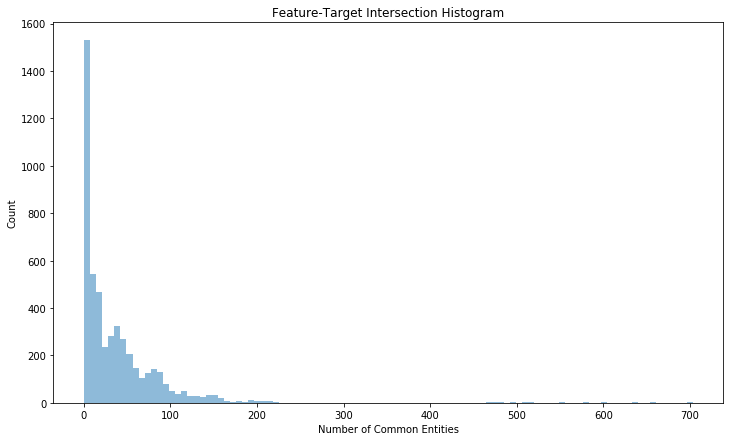

In [26]:
# Visualize feature-target intersection histogram
plt.figure(figsize=(12, 7))
n, bins, patches = plt.hist(intersect_lengths, 100, alpha=0.5)
plt.title('Feature-Target Intersection Histogram')
plt.ylabel('Count')
plt.xlabel('Number of Common Entities')
plt.savefig('./images/feat_target_inter.png')
plt.show()

From the histogram shown above, it can be seen that a majority of the features do not share any common values with the target. That being said, there seem to be a few features that share a startling number of values with the target.

Around the middle of July (2018), there was a massive upset of the Santander competition leaderboard where it was revealed that the datasets provided by Santander were actually scrambled time-series data both along the rows and columns. From that point onwards, many of the public Kaggle kernels focused on locating features in the training and test datasets that could help in the reconstruction of this time-series dataset. Proposed feature sets have been made public-knowledge on these forums.

To validate these publicly posted features, I will be comparing them with the features shown in the sparse end of the long-tail distribution shown above. The exact features are taken from: https://www.kaggle.com/johnfarrell/breaking-lb-fresh-start-with-lag-selection

In [45]:
# Important features as identified by Kaggle
kags = ['f190486d6', '58e2e02e6', 'eeb9cd3aa', '9fd594eec', '6eef030c1', '15ace8c9f', 
        'fb0f5dbfe', '58e056e12', '20aa07010', '024c577b9', 'd6bb78916', 'b43a7cfd5', 
        '58232a6fb', '1702b5bf0', '324921c7b', '62e59a501', '2ec5b290f', '241f0f867', 
        'fb49e4212', '66ace2992', 'f74e8f13d', '5c6487af1', '963a49cdc', '26fc93eb7', 
        '1931ccfdd', '703885424', '70feb1494', '491b9ee45', '23310aa6f', 'e176a204a', 
        '6619d81fc', '1db387535', 'fc99f9426', '91f701ba2', '0572565c2', '190db8488', 
        'adb64ff71', 'c47340d97', 'c5a231d81', '0ff32eb98'
       ]
kags = np.array(kags)

In [56]:
important_idx = np.where(intersect_lengths>300)[0]
important_cols = fnames[important_idx]

In [49]:
# Check if Kaggle indexes are equivalent to indexes I discovered
np.array_equal(np.sort(kags), np.sort(important_cols))

True

From this result, it is determined that the Kaggle community most likely decided upon these features through an analysis similar to my own - that is, selecting the features that share the most similarites to the target variable.

One last thing to note is that while I've verified the features, I haven't verified the proper order in which they are presented in within the Kaggle community. The order of these features is extremely significant since the proper sequence is required to reconstruct the time-series nature of the dataset. I will not be double-checking this facet of the Kaggle community's findings and will proceed using their proposed ordering.

In [64]:
# Save important columns into pickle file
cols_fname = './important.pickle'
with open(cols_fname, 'wb') as handle:
    pickle.dump(kags, handle, protocol=pickle.HIGHEST_PROTOCOL)